# trainTWO model8_FORSYTHIA

WITH SENTENCE : 개나리 노오란 꽃 그늘 아래

forsythiaTWO = {0:'flower', 1:'shadow_', 2:'below'}

- forsythiaTWO.h5(1): 200/200/200 // epoch=50 // acc:98%
- forsythiaTWO.h5(2): 200/400/400 // epoch=50 // acc:100%
- forsythiaTWO.h5(3):       epoch=50
- forsythiaTWO.h5(4):       epoch=50
- forsythiaTWO.h5(5):      epoch=50

In [4]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [1]:
#드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from itertools import chain

forsythiaTWO = {0:'flower', 1:'shadow_', 2:'below'}
actions = []

for v in forsythiaTWO.values():
    actions.append(v)
print(actions)

['flower', 'shadow_', 'below']


In [15]:
# cloudTWO
data = np.concatenate([
                       # below : 400
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/forsythiaTWO/two_SL_below_1635908069.npy'),
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/forsythiaTWO/two_SL_below_1635908666.npy'),
                       # flower : 200
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/forsythiaTWO/two_SL_flower_1635908069.npy'),
                       # shadow_ : 400
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/forsythiaTWO/two_SL_shadow__1635908069.npy'),
                       np.load('/content/drive/MyDrive/SOOWA/datasetTWO/modelTWO8/forsythiaTWO/two_SL_shadow__1635908666.npy')
                       
               
], axis=0)

data.shape

(950, 10, 144)

In [16]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(950, 10, 143)
(950,)


In [17]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(950, 3)

In [18]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(855, 10, 143) (855, 3)
(95, 10, 143) (95, 3)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                53248     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 55,427
Trainable params: 55,427
Non-trainable params: 0
_________________________________________________________________


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
27/27 [==============================] - 2s 17ms/step - loss: 54.3594 - acc: 0.4152 - val_loss: 28.0928 - val_acc: 0.5579

Epoch 00001: val_acc improved from -inf to 0.55789, saving model to models/model.h5
Epoch 2/50
27/27 [==============================] - 0s 8ms/step - loss: 11.1177 - acc: 0.7099 - val_loss: 8.4007 - val_acc: 0.7158

Epoch 00002: val_acc improved from 0.55789 to 0.71579, saving model to models/model.h5
Epoch 3/50
27/27 [==============================] - 0s 8ms/step - loss: 1.4924 - acc: 0.8620 - val_loss: 0.8259 - val_acc: 0.9158

Epoch 00003: val_acc improved from 0.71579 to 0.91579, saving model to models/model.h5
Epoch 4/50
27/27 [==============================] - 0s 8ms/step - loss: 0.4642 - acc: 0.9392 - val_loss: 0.2000 - val_acc: 0.9789

Epoch 00004: val_acc improved from 0.91579 to 0.97895, saving model to models/model.h5
Epoch 5/50
27/27 [==============================] - 0s 8ms/step - loss: 0.1465 - acc: 0.9684 - val_loss: 0.0656 - val_acc: 0.98

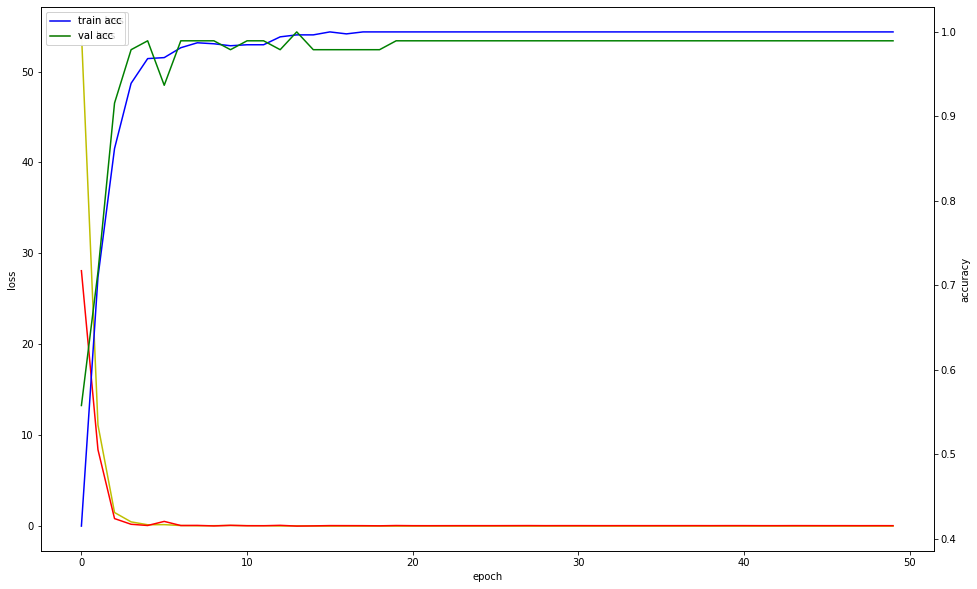

In [21]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [22]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[71,  0],
        [ 0, 24]],

       [[58,  0],
        [ 0, 37]],

       [[61,  0],
        [ 0, 34]]])

In [23]:
from keras.models import load_model

model.save('forsythiaTWO.h5')

from google.colab import files
files.download('forsythiaTWO.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>